In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

from utils import make_precinct_counts,make_demo_map,job_cols,race_cols,cols_to_keep,scale_and_cluster,make_edname,map_round_votes

from shapely import wkt

import seaborn as sns
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import PCA
from factor_analyzer import calculate_kmo, calculate_bartlett_sphericity

demo_cluster = pd.read_csv('../../chapter_two/data/occupation_demo_clusters_on_ed.csv')
ed_level = pd.read_csv('../../cc_election_cleaning/occupation_demo_data_feb21.csv')

ed_shapefile = '../../chapter_two/data/nyed_21a/nyed.shp'
ed_gdf = gpd.read_file(ed_shapefile)

full_results = pd.read_csv('../../cc_election_cleaning/election_results_with_vote_sponsor_cluster_FEB13.csv')
jw = full_results[full_results['candidate'] == 'Julie Won']

ae = pd.read_csv('../../cc_election_cleaning/ae_precincts.csv')
av = pd.read_csv('../../cc_election_cleaning/additional_variables.csv')
fwe = pd.read_csv('../data/finance_with_ethnicity.csv')
f_plus = pd.read_csv('../../council_campaign_finance/data/iwrl_plus.csv')
occ_df = pd.read_csv('../../cc_election_cleaning/occupation_election_feb21.csv')

p_cols = [col for col in occ_df.columns if col[-1] == 'p']
wp_cols = [col for col in occ_df.columns if col.startswith("w2") and col.endswith("p")]
wp_cols.remove('w2cop')
to_remove = [ 'w2psp',
 'w2sep',
 'w2npp',
 'w2govp',
 'w2nip']
wp_cols = [col for col in wp_cols if col not in to_remove]
demo_cols = ['nhw21p','nhb21p','h21p','nha21p','cvap21bapp','mhhi21']

In [2]:

import contextily as ctx

In [3]:
jw = gpd.GeoDataFrame(jw,geometry=jw['geometry'].apply(wkt.loads))
jw = jw.set_crs(epsg=2263, allow_override=True)
co_3857 = jw.to_crs(epsg=3857)

In [4]:
aal = pd.read_csv('../../cc_election_cleaning/precincts_leins.csv')
yd = pd.read_csv('../../cc_election_cleaning/yiddish_precincts.csv')
dt = pd.read_csv('../../cc_election_cleaning/degree_type.csv')
all_rounds = pd.read_csv('../../cc_election_cleaning/all_rounds_results/district_26.csv')

In [5]:
demo_occ = jw[['vote_share','ed_name','nhw21p','nhb21p','h21p','nha21p','cvap21bapp','mhhi21','venez21p','chin21p',
                 'kor21p','colomb21p','domin21p','mex21p','white_transplant_ratio','prican21p','winda21p']].merge(occ_df, left_on='ed_name', right_on='ElectDist', how='left')

In [6]:
demo_occ = demo_occ.merge(ae[['ElectDist','ind21p','bang21p','pak21p','filip21p']],on = 'ElectDist',how='left')
demo_occ = demo_occ.merge(av,on='ElectDist',how='left')
demo_occ = demo_occ.merge(yd,on = 'ElectDist', how='left')
demo_occ = demo_occ.merge(dt,on = 'ElectDist', how='left')

In [7]:
demo_occ['log_mhhi21'] = np.log(demo_occ['mhhi21'])

In [17]:
cor_cols = demo_occ.drop(columns=['ElectDist','ed_name','geometry_x','geometry_y']).columns.tolist()
cor_matrix = demo_occ[cor_cols].corr()
cor_matrix.dropna(subset=('vote_share'),inplace=True)
cor_matrix.sort_values(by='vote_share', ascending=False).head(15)

vote_share    nhw21p    nhb21p      h21p    nha21p  \
vote_share                1.000000  0.405584 -0.463968 -0.325433  0.289448   
cvap21bapp                0.613585  0.768182 -0.634215 -0.593468  0.240927   
w2mgtp                    0.473028  0.752761 -0.394743 -0.620253  0.029149   
log_mhhi21                0.463672  0.357062 -0.393314 -0.356440  0.301956   
wm2                       0.450057  0.242135 -0.263842 -0.297234  0.241086   
wm2mgt                    0.430803  0.468798 -0.112085 -0.583226  0.046474   
white_transplant_ratio    0.415963  0.846412 -0.196503 -0.742646 -0.192522   
nhw21p                    0.405584  1.000000 -0.424798 -0.647013 -0.217228   
w2                        0.405278  0.234243 -0.207997 -0.328765  0.218899   
wps2                      0.395934  0.195633 -0.206207 -0.296286  0.238988   
w2mgt                     0.393949  0.409888 -0.087320 -0.553807  0.067287   
w2mgr                     0.393841  0.413699 -0.112579 -0.540107  0.070016   
wps2mgr                   0.393590  0.397253 -0.101683 -0.537455  0.078430   
wf2lps                    0.387036  0.373648 -0.187508 -0.481751  0.155477   
wm2adesm                  0.384396  0.555732 -0.100394 -0.566328 -0.097678   

                        cvap21bapp    mhhi21  venez21p   chin21p    kor21p  \
vote_share                0.613585  0.297237 -0.438813  0.148731  0.305904   
cvap21bapp                1.000000  0.424316 -0.409515  0.318852  0.550103   
w2mgtp                    0.799807  0.211583 -0.290519  0.185223  0.570847   
log_mhhi21                0.553454  0.861998 -0.330258  0.136476  0.399386   
wm2                       0.476436  0.764882 -0.207047  0.180029  0.355219   
wm2mgt                    0.617497  0.697098 -0.217126  0.210978  0.405739   
white_transplant_ratio    0.734375  0.305223 -0.285355 -0.016905  0.250447   
nhw21p                    0.768182  0.207928 -0.308905 -0.081459  0.295691   
w2                        0.448523  0.766309 -0.179612  0.183763  0.368942   
wps2                      0.424428  0.763368 -0.159189  0.181333  0.352100   
w2mgt                     0.576283  0.720209 -0.194929  0.214998  0.478715   
w2mgr                     0.582255  0.764346 -0.169341  0.212530  0.471517   
wps2mgr                   0.581973  0.761489 -0.154086  0.223763  0.455403   
wf2lps                    0.443054  0.495277 -0.216805  0.133267  0.343710   
wm2adesm                  0.558325  0.679970 -0.196431  0.034729  0.331659   

                        ...   arab21p   fb21bdp   fb21drp   hh21bop     rateE  \
vote_share              ...  0.164089 -0.015807 -0.192674  0.121915  0.324520   
cvap21bapp              ...  0.152208 -0.213216 -0.398930  0.021649  0.519516   
w2mgtp                  ...  0.126838 -0.303542 -0.364665  0.130531  0.386089   
log_mhhi21              ...  0.024235 -0.028530 -0.430727  0.129995  0.539817   
wm2                     ...  0.087837 -0.041364 -0.188071  0.060524  0.526885   
wm2mgt                  ...  0.087178 -0.277362 -0.313581 -0.025199  0.607475   
white_transplant_ratio  ...  0.046906 -0.253841 -0.364133 -0.007242  0.400468   
nhw21p                  ...  0.059427 -0.383199 -0.368150 -0.037934  0.347307   
w2                      ...  0.068294 -0.058256 -0.181789  0.043275  0.498754   
wps2                    ...  0.033491 -0.024264 -0.128695  0.022163  0.504076   
w2mgt                   ...  0.058377 -0.238289 -0.286794  0.054691  0.567729   
w2mgr                   ...  0.062236 -0.229702 -0.267098 -0.004236  0.572848   
wps2mgr                 ...  0.029817 -0.204937 -0.233235 -0.014251  0.604582   
wf2lps                  ... -0.018985 -0.104439 -0.252319 -0.159824  0.430748   
wm2adesm                ... -0.001971 -0.239892 -0.324028  0.038408  0.508013   

                           st_hu  TOTAL_HUMD_pct  TOTAL_STEMD_pct  \
vote_share              0.203154        0.104962         0.060867   
cvap21bapp              0.208405        0.024895         0.109124   
w2mgtp                

In [45]:
test_cols = ['nhw21p','nhb21p','h21p','nha21p','cvap21bapp','log_mhhi21','venez21p','chin21p','kor21p','colomb21p','domin21p',
'mex21p','white_transplant_ratio','ind21p','bang21p','pak21p','filip21p','greek21p','arab21p',
'fb21bdp','fb21drp','hh21bop','st_hu'] + wp_cols

In [46]:
cor_matrix = demo_occ[test_cols].corr()
cor_matrix.dropna(subset=('vote_share'),inplace=True)
cor_matrix.sort_values(by='vote_share', ascending=False)

KeyError: ['vote_share']

In [47]:
kmo_all, kmo_model = calculate_kmo(demo_occ[test_cols])
chi_square_value, p_value = calculate_bartlett_sphericity(demo_occ[test_cols])

print("KMO per item:", kmo_all)
print("Overall KMO:", kmo_model)       
print("Bartlett’s test χ²:", chi_square_value, "p-value:", p_value) 

KMO per item: [0.4899599  0.40256072 0.47812887 0.34380147 0.62788043 0.65209554
 0.52665077 0.24503197 0.38779168 0.25661751 0.54445687 0.58121697
 0.57105096 0.48457923 0.39386202 0.15943753 0.291112   0.18871361
 0.15075723 0.58349745 0.35265573 0.21075408 0.34062251 0.52179249
 0.45908001 0.29175499 0.17972549 0.40891731 0.34703201 0.58239755
 0.39637577 0.51107567 0.27098955 0.3247258  0.57120784 0.26582175
 0.18367215 0.37599063 0.66366663 0.34634837 0.31171988 0.30475906
 0.11102028 0.46995366 0.45040182 0.18631815 0.40102775 0.28763471]
Overall KMO: 0.39585409365273644
Bartlett’s test χ²: 5444.412899871505 p-value: 0.0


In [48]:
def iterative_kmo_prune(df, threshold_item=0.50, threshold_overall=0.60):
    from factor_analyzer import calculate_kmo
    df_current = df.copy()
    while True:
        kmo_items, kmo_overall = calculate_kmo(df_current)
        worst_idx = kmo_items.argmin()
        if (kmo_overall >= threshold_overall and 
            all(kmo_items >= threshold_item)):
            break
        drop_var = df_current.columns[worst_idx]
        print(f"Dropping '{drop_var}' (KMO={kmo_items[worst_idx]:.3f}); new overall KMO before recalculation = {kmo_overall:.3f}")
        df_current = df_current.drop(columns=[drop_var])
    return df_current

In [49]:
pruned_df = iterative_kmo_prune(demo_occ[test_cols])

Dropping 'w2farmp' (KMO=0.111); new overall KMO before recalculation = 0.396
Dropping 'pak21p' (KMO=0.139); new overall KMO before recalculation = 0.417
Dropping 'arab21p' (KMO=0.135); new overall KMO before recalculation = 0.434
Dropping 'greek21p' (KMO=0.144); new overall KMO before recalculation = 0.499
Dropping 'w2aep' (KMO=0.218); new overall KMO before recalculation = 0.523
Dropping 'w2copp' (KMO=0.283); new overall KMO before recalculation = 0.542
Dropping 'w2prodp' (KMO=0.319); new overall KMO before recalculation = 0.565
Dropping 'colomb21p' (KMO=0.328); new overall KMO before recalculation = 0.567
Dropping 'chin21p' (KMO=0.333); new overall KMO before recalculation = 0.584
Dropping 'hh21bop' (KMO=0.360); new overall KMO before recalculation = 0.606
Dropping 'w2oadp' (KMO=0.359); new overall KMO before recalculation = 0.608
Dropping 'w2cmp' (KMO=0.356); new overall KMO before recalculation = 0.612
Dropping 'w2docp' (KMO=0.396); new overall KMO before recalculation = 0.629
Drop

In [50]:
predictors = pruned_df.columns.tolist()
X = demo_occ[predictors]

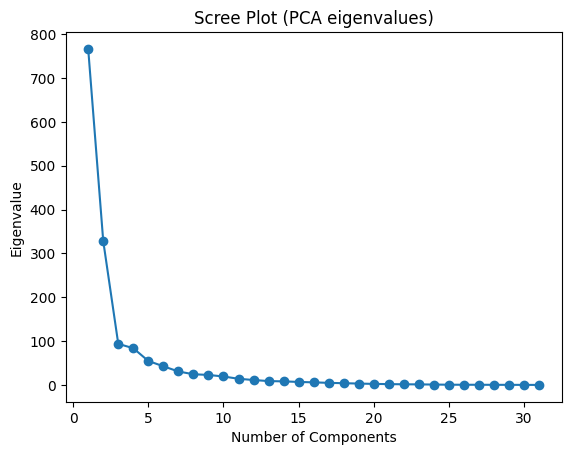

In [51]:
pca = PCA()
pca.fit(X)

ev = pca.explained_variance_

plt.plot(range(1, len(ev) + 1), ev, marker='o')
plt.title('Scree Plot (PCA eigenvalues)')
plt.xlabel('Number of Components')
plt.ylabel('Eigenvalue')
plt.show()

In [52]:
n_factors = 5
fa = FactorAnalysis(n_components=n_factors, random_state=0)
factor_scores = fa.fit_transform(X)

In [53]:
fa_df = pd.DataFrame(
    factor_scores,
    columns=[f'Factor{i+1}' for i in range(n_factors)],
    index=demo_occ.index
)

In [54]:
loadings = pd.DataFrame(
    fa.components_.T,
    index=predictors,
    columns=fa_df.columns
)
print("Factor Loadings:\n", loadings)

Factor Loadings:
                           Factor1   Factor2   Factor3   Factor4   Factor5
nhw21p                  13.946321  1.345878  0.653982  2.669161 -3.860721
nhb21p                  -5.281053 -6.394498  8.895202 -0.296413  1.681427
h21p                    -7.816748 -2.571533 -5.811013 -2.161545 -2.316717
cvap21bapp              15.901832  6.070533 -3.177223  0.685702  1.080123
log_mhhi21               0.397777  0.244709 -0.235710  0.413359  0.389263
venez21p                -0.356543 -0.189495  0.374142 -0.174095 -0.129725
kor21p                   1.160070  0.671790 -0.259394 -0.649700  0.831758
domin21p                -1.713864 -0.916613 -0.159672 -0.858552 -1.359462
mex21p                  -1.741801  1.369370 -3.373060 -0.555793  0.606957
white_transplant_ratio   5.349341  0.867120  1.726640  2.194933 -0.944471
ind21p                  -0.056767  1.996660 -0.798263  0.329718  0.421901
bang21p                 -2.247279  2.744173  1.085652 -0.204898 -0.332697
fb21bdp             

In [55]:
Y = demo_occ['vote_share']
model_fa = sm.OLS(Y, sm.add_constant(fa_df)).fit()
print(model_fa.summary())

                            OLS Regression Results                            
Dep. Variable:             vote_share   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                     11.91
Date:                Thu, 02 Oct 2025   Prob (F-statistic):           6.79e-09
Time:                        16:11:35   Log-Likelihood:                -306.17
No. Observations:                  98   AIC:                             624.3
Df Residuals:                      92   BIC:                             639.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.1995      0.574     29.980      0.0

Multiple rounds 

In [48]:
all_rounds.groupby('district_26_choice_1')['district_26_choice_2'].value_counts(dropna=False).reset_index(name='count').sort_values(by='count',ascending=False)

district_26_choice_1 district_26_choice_2  count
0          Amit S. Bagga            Julie Won    710
188            Julie Won           Hailie Kim    669
189            Julie Won        Amit S. Bagga    527
190            Julie Won                  NaN    505
1          Amit S. Bagga         Jesse Laymon    492
..                   ...                  ...    ...
238       Steven B. Raga             overvote      1
255      Sultan Al Maruf             Write-in      1
256      Sultan Al Maruf             overvote      1
265             Write-in       Ebony R. Young      1
286             overvote        Amit S. Bagga      1

[287 rows x 3 columns]

In [28]:
def aggregate_precinct_counts(df,
                              cand1,
                              cand2,
                              choice1_col='district_33_choice_1',
                              choice2_col='district_33_choice_2',
                              count_col='count',
                              ed_col='ed_name'):
    """
    Aggregate counts for combinations of two candidates on choice1 and choice2.
    cand1 / cand2 may be a string or a list of equivalent name strings (aliases).
    Returns a dataframe grouped by ed_col with summed columns and percentage shares.
    """
    df = df.copy()

    # normalize inputs to lists (so user can pass "Sandy Nurse" or ["Sandy Nurse", "S. Nurse"])
    cand1_list = cand1 if isinstance(cand1, (list, tuple, set)) else [cand1]
    cand2_list = cand2 if isinstance(cand2, (list, tuple, set)) else [cand2]

    c1 = choice1_col
    c2 = choice2_col
    cnt = count_col
    ed = ed_col

    mask_c1_c2 = df[c1].isin(cand1_list) & df[c2].isin(cand2_list)
    mask_c1_notc2 = df[c1].isin(cand1_list) & ~df[c2].isin(cand2_list)
    mask_c2_c1 = df[c1].isin(cand2_list) & df[c2].isin(cand1_list)
    mask_c2_notc1 = df[c1].isin(cand2_list) & ~df[c2].isin(cand1_list)
    mask_neither = ~df[c1].isin(cand1_list + cand2_list)

    # column names are generated dynamically so function is generic
    col_c1_c2 = f"{cand1_list[0].replace(' ','_').lower()}_{cand2_list[0].replace(' ','_').lower()}"
    col_c1_notc2 = f"{cand1_list[0].replace(' ','_').lower()}_not_{cand2_list[0].replace(' ','_').lower()}"
    col_c2_c1 = f"{cand2_list[0].replace(' ','_').lower()}_{cand1_list[0].replace(' ','_').lower()}"
    col_c2_notc1 = f"{cand2_list[0].replace(' ','_').lower()}_not_{cand1_list[0].replace(' ','_').lower()}"

    df[col_c1_c2] = df[cnt] * mask_c1_c2.astype(int)
    df[col_c1_notc2] = df[cnt] * mask_c1_notc2.astype(int)
    df[col_c2_c1] = df[cnt] * mask_c2_c1.astype(int)
    df[col_c2_notc1] = df[cnt] * mask_c2_notc1.astype(int)
    df['neither'] = df[cnt] * mask_neither.astype(int)

    grouped = df.groupby(ed)[[col_c1_c2, col_c1_notc2, col_c2_c1, col_c2_notc1, 'neither']].sum().reset_index()

    # totals and shares (avoid division by zero)
    grouped['total'] = grouped[[col_c1_c2, col_c1_notc2, col_c2_c1, col_c2_notc1, 'neither']].sum(axis=1)
    for col in [col_c1_c2, col_c1_notc2, col_c2_c1, col_c2_notc1]:
        grouped[f"share_{col}_pct"] = (grouped[col] / grouped['total'] * 100).round(2).fillna(0)

    # biggest among the four (excludes 'neither'); if tie, idxmax returns first max
    grouped['biggest'] = grouped[[col_c1_c2, col_c1_notc2, col_c2_c1, col_c2_notc1]].idxmax(axis=1)

    return grouped


In [32]:
all_rounds = make_edname(all_rounds)
second_choice = all_rounds.groupby(['ed_name','district_26_choice_1'])['district_26_choice_2'].value_counts(dropna=False).reset_index(name='count')

In [33]:
second_choice

ed_name district_26_choice_1 district_26_choice_2  count
0       30038        Amit S. Bagga            Julie Won     12
1       30038        Amit S. Bagga         Jesse Laymon     10
2       30038        Amit S. Bagga      Julia L. Forman      8
3       30038        Amit S. Bagga        Brent O'Leary      5
4       30038        Amit S. Bagga                  NaN      4
...       ...                  ...                  ...    ...
7738    39022       Steven B. Raga           Hailie Kim      1
7739    39022       Steven B. Raga        Amit S. Bagga      1
7740    39022      Sultan Al Maruf          Badrun Khan      3
7741    39022      Sultan Al Maruf         Jesse Laymon      1
7742    39022      Sultan Al Maruf            Julie Won      1

[7743 rows x 4 columns]

In [38]:
ag = aggregate_precinct_counts(second_choice, "Julie Won", "Amit S. Bagga",choice1_col='district_26_choice_1',
                               choice2_col='district_26_choice_2')

In [49]:
ag.sample(5)

ed_name  julie_won_amit_s._bagga  julie_won_not_amit_s._bagga  \
24    30066                        8                           30   
94    37080                       18                           59   
47    34071                        1                           21   
0     30038                        3                           34   
67    37020                        6                           51   

    amit_s._bagga_julie_won  amit_s._bagga_not_julie_won  neither  total  \
24                        7                           27      135    207   
94                       13                           44      136    270   
47                        2                           20      111    155   
0                        12                           33      111    193   
67                        6                           20       84    167   

    share_julie_won_amit_s._bagga_pct  share_julie_won_not_amit_s._bagga_pct  \
24                               3.86                                  14.49   
94                               6.67                                  21.85   
47                               0.65                                  13.55   
0                                1.55                                  17.62   
67                               3.59                                  30.54   

    share_amit_s._bagga_julie_won_pct  share_amit_s._bagga_not_julie_won_pct  \
24                               3.38                                  13.04   
94                               4.81                                  16.30   
47                               1.29                                  12.90   
0                                6.22                                  17.10   
67                               3.59                                  11.98   

                        biggest  
24  julie_won_not_amit_s._bagga  
94  julie_won_not_amit_s._bagga  
47  julie_won_not_amit_s._bagga  
0   julie_won_not_amit_s._bagga  
67  julie_won_not_amit_s._bagga

In [45]:
co_3857 = co_3857.merge(ag, on='ed_name',how='left')

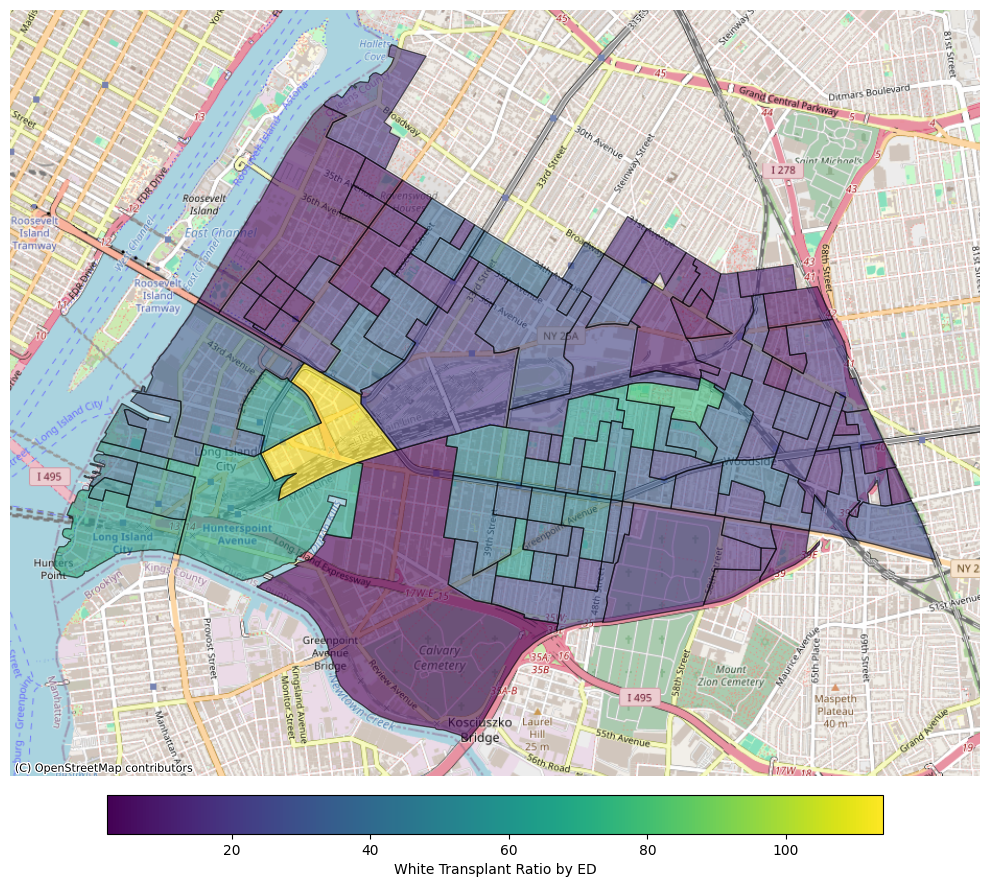

In [43]:
fig, ax = plt.subplots(figsize=(10, 10))
co_3857.plot(
    column='julie_won_not_amit_s._bagga',
    legend=True,
    legend_kwds={
        "label": "White Transplant Ratio by ED",
        "orientation": "horizontal",
        "shrink": 0.8,         # fraction of original size
        "pad": 0.02            # space between map and bar
    },
    ax=ax,
    alpha=0.6,
    edgecolor="k",
    cmap="viridis",
)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_axis_off()
plt.tight_layout()
plt.show()

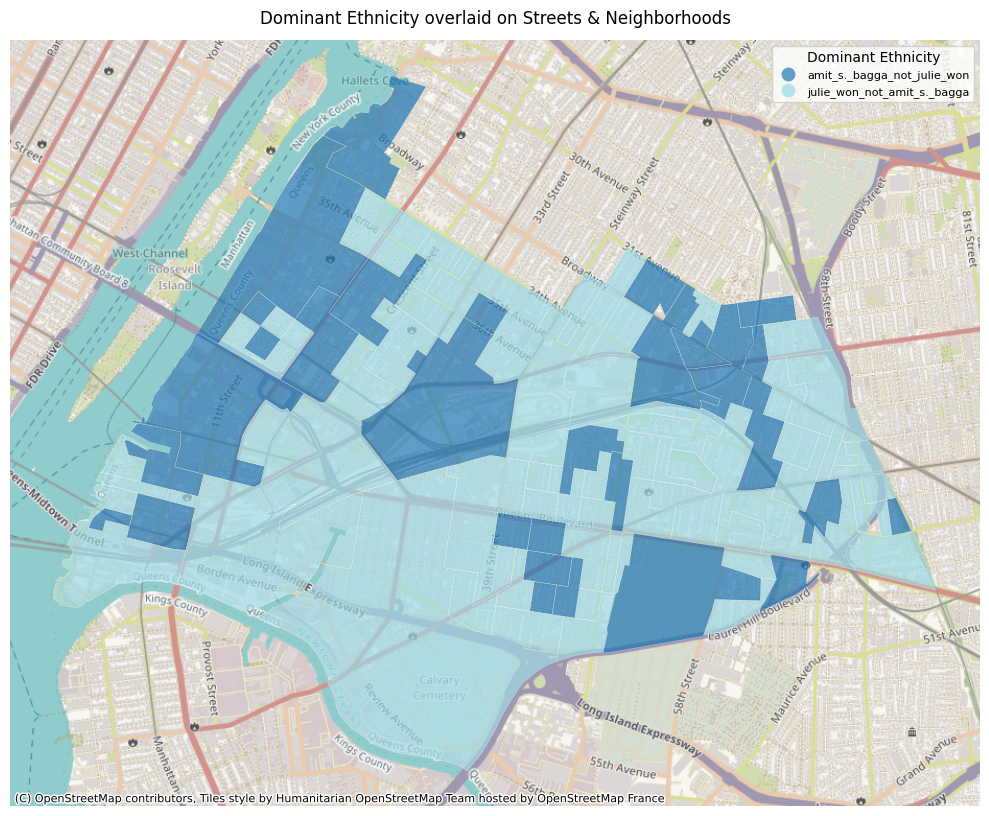

In [46]:
fig, ax = plt.subplots(figsize=(10, 10))

co_3857.plot(
    column='biggest',
    categorical=True,
    cmap='tab20',
    legend=True,
    alpha=0.7,
    ax=ax,
    edgecolor='white',
    linewidth=0.2,
    legend_kwds={'title': 'Dominant Ethnicity', 'fontsize': 8, 'title_fontsize': 10}
)

ctx.add_basemap(
    ax,
    #source=ctx.providers.CartoDB.Positron,  
    zoom=14   
)

ax.set_axis_off()
ax.set_title("Dominant Ethnicity overlaid on Streets & Neighborhoods", pad=12)

plt.tight_layout()
plt.show()

In [16]:
demo_occ_map = gpd.GeoDataFrame(demo_occ,geometry=demo_occ['geometry_x'].apply(wkt.loads))
gdf = demo_occ_map.copy()

In [17]:
eth_cols = ['ind21p','bang21p','domin21p','venez21p','mex21p','white_transplant_ratio','winda21p','colomb21p',
            'chin21p','kor21p','domin21p','prican21p']
red_eth_cols = ['nhw21p','nhb21p','h21p','nha21p']

In [18]:
gdf['laptop'] = gdf['w2admp'] + gdf['w2banp'] + gdf['w2cmp']

gdf['dom_eth']   = gdf[eth_cols].idxmax(axis=1)  
gdf['dom_eth_p'] = gdf[eth_cols].max(axis=1)     

gdf['dom_red_eth']   = gdf[red_eth_cols].idxmax(axis=1)
gdf['dom_red_eth_p'] = gdf[red_eth_cols].max(axis=1)

gdf['dom_occ']   = gdf[wp_cols].idxmax(axis=1)
gdf['dom_occ_p'] = gdf[wp_cols].max(axis=1)

In [19]:
gdf = gdf.set_crs(epsg=2263, allow_override=True)
gdf_3857 = gdf.to_crs(epsg=3857)

In [27]:
occ_label_map = {
    'w2admp': 'Designers & Journalists',
    'w2banp': 'Analyst Specialist',
    'w2bgp': 'Janitorial',
    'w2conp': 'Construction',
    'w2copp': 'Law Enforcement',
    'w2foodp': 'Food Service',
    'w2hsp': 'Homecare',
    'w2mgtp': 'Management',
    'w2oadp': 'Office Admin',
    'w2salep': 'Sales',
    'w2prodp': 'Manual Production',
    'w2bgp' : 'Janitorial',
    'w2cmp' :'Software Engineers'
}

gdf_3857['occupation_label'] = gdf_3857['dom_occ'].map(occ_label_map)
gdf_3857['occupation_label'] = gdf_3857['occupation_label'].astype('category')

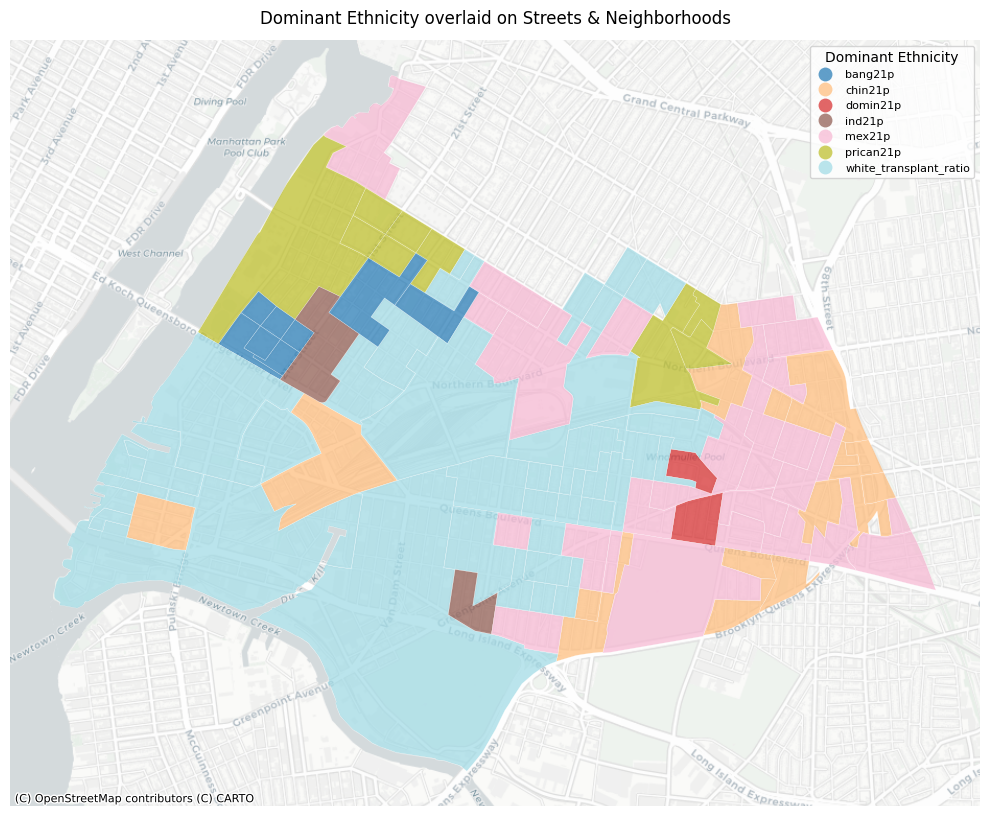

In [30]:
fig, ax = plt.subplots(figsize=(10, 10))

gdf_3857.plot(
    column='dom_eth',
    categorical=True,
    cmap='tab20',
    legend=True,
    alpha=0.7,
    ax=ax,
    edgecolor='white',
    linewidth=0.2,
    legend_kwds={'title': 'Dominant Ethnicity', 'fontsize': 8, 'title_fontsize': 10}
)


ctx.add_basemap(
    ax,
    source=ctx.providers.CartoDB.Positron,  
    zoom=14   
)

# 5) Clean up
ax.set_axis_off()
ax.set_title("Dominant Ethnicity overlaid on Streets & Neighborhoods", pad=12)

plt.tight_layout()
plt.show()

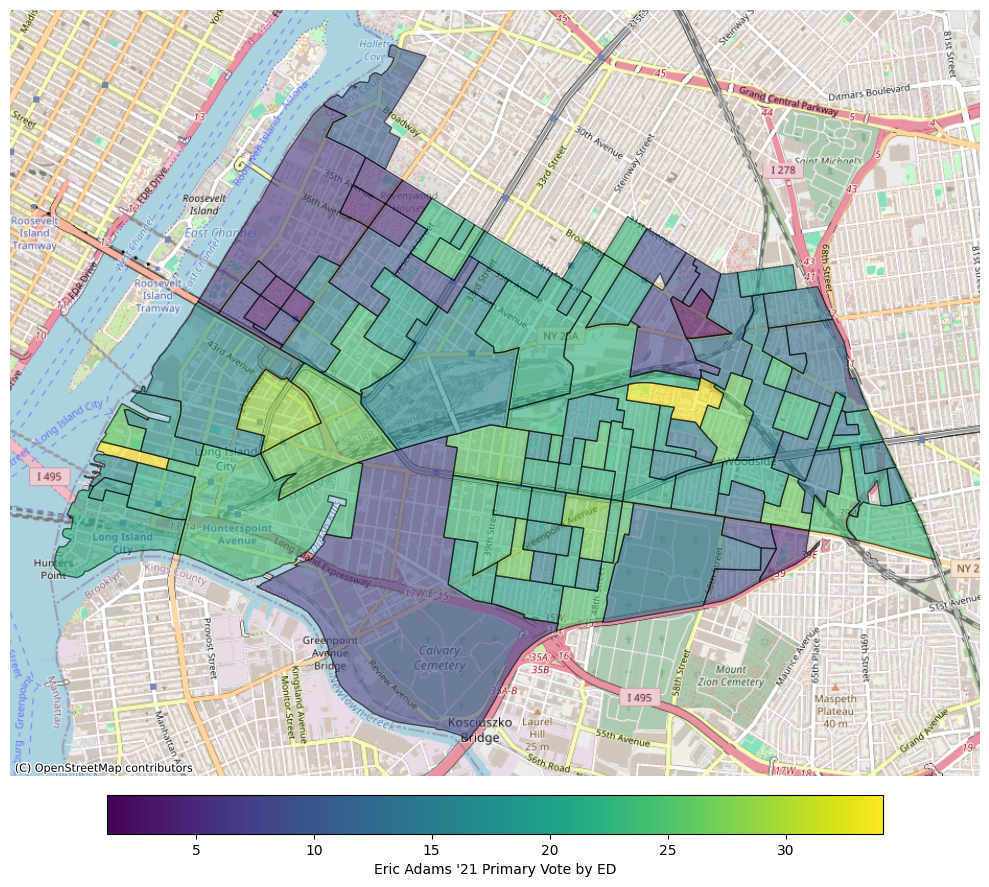

In [31]:
fig, ax = plt.subplots(figsize=(10, 10))
co_3857.plot(
    column="vote_share",
    legend=True,
    legend_kwds={
        "label": "Eric Adams '21 Primary Vote by ED",
        "orientation": "horizontal",
        "shrink": 0.8,        
        "pad": 0.02            
    },
    ax=ax,
    alpha=0.6,
    edgecolor="k",
    cmap="viridis",
)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [18]:
wc = pd.read_csv('../data/won_contributions.csv')
bc = pd.read_csv('../data/bagga_contributions.csv')

In [29]:
wc.columns

Index(['ELECTION', 'OFFICECD', 'RECIPID', 'CANCLASS', 'RECIPNAME', 'COMMITTEE',
       'FILING', 'SCHEDULE', 'PAGENO', 'SEQUENCENO', 'REFNO', 'DATE',
       'REFUNDDATE', 'NAME', 'C_CODE', 'STRNO', 'STRNAME', 'APARTMENT',
       'BOROUGHCD', 'CITY', 'STATE', 'ZIP', 'OCCUPATION', 'EMPNAME',
       'EMPSTRNO', 'EMPSTRNAME', 'EMPCITY', 'EMPSTATE', 'AMNT', 'MATCHAMNT',
       'PREVAMNT', 'PAY_METHOD', 'INTERMNO', 'INTERMNAME', 'INTSTRNO',
       'INTSTRNM', 'INTAPTNO', 'INTCITY', 'INTST', 'INTZIP', 'INTEMPNAME',
       'INTEMPSTNO', 'INTEMPSTNM', 'INTEMPCITY', 'INTEMPST', 'INTOCCUPA',
       'PURPOSECD', 'EXEMPTCD', 'ADJTYPECD', 'RR_IND', 'SEG_IND',
       'INT_C_CODE'],
      dtype='object')

In [48]:
wc[['REFNO', 'DATE', 'REFUNDDATE', 'NAME', 'C_CODE','OCCUPATION', 'EMPNAME','EMPSTRNO','AMNT']].sample(10)

REFNO        DATE  REFUNDDATE                 NAME C_CODE  \
711  R0002134  12/17/2020         NaN          Warren, Lis    IND   
519  R0000134   8/23/2020         NaN         nam, haesook    IND   
184  R0004081   5/17/2021         NaN   Dona-Couch, Andrew    IND   
115  R0000443   9/16/2020         NaN          Choi, Grace    IND   
529  R0003633    3/7/2021         NaN         Nguyen, Thao    IND   
505  R0002221  12/18/2020         NaN       Min, Catherine    IND   
414  R0002945    1/5/2021         NaN           Lee, Janet    IND   
666  R0002022  12/15/2020         NaN           Soto, Eric    IND   
420  R0001215  10/31/2020         NaN           Lee, Joann    IND   
619  R0002946    1/5/2021         NaN  Rodriguez, Victoria    IND   

                 OCCUPATION                         EMPNAME EMPSTRNO   AMNT  
711             UX Designer                          Optoro     1001   25.0  
519               President                   Self-Employed      917   25.0  
184      Software Developer                   Self-Employed      444   10.0  
115                Director        New York City Government    26-20  250.0  
529      Technology Manager                       ViacomCBS     1515   25.0  
505  Occupational Therapist  Metro Occupational /Physical T      800   25.0  
414         Studio Director       Something Special Studios      138  450.0  
666                 Student                             NaN      NaN   25.0  
420      design coordinator                             DPC      350   35.0  
619      Compliance Officer                       Citigroup      480  130.0

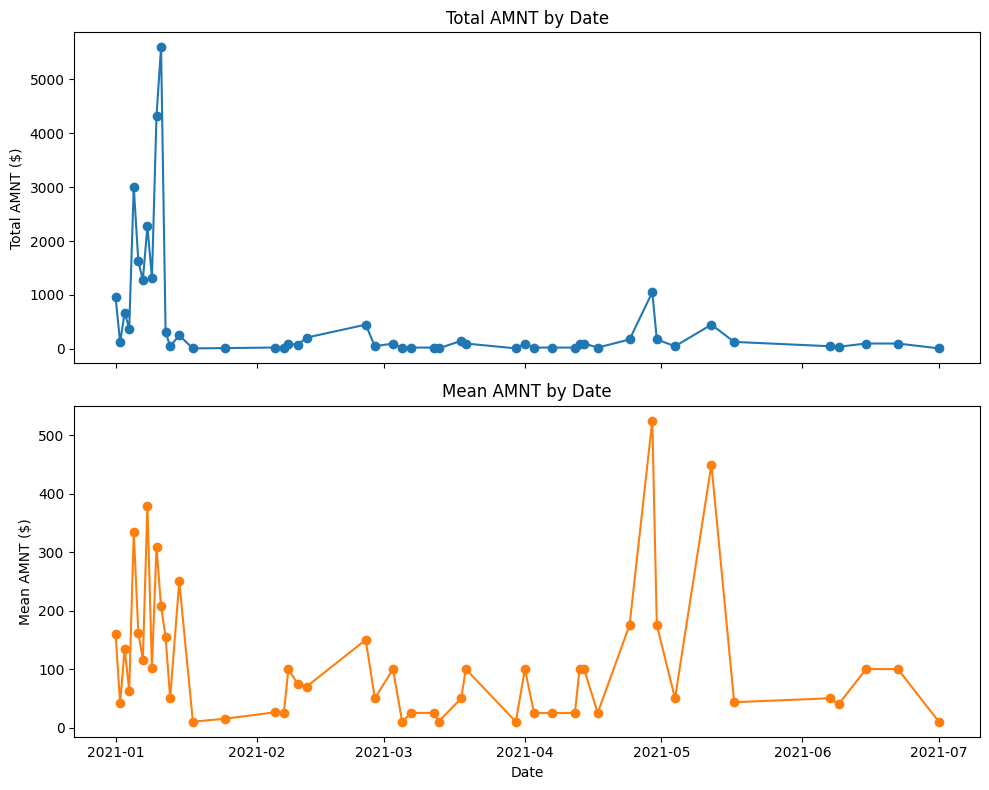

In [57]:
wc['DATE'] = pd.to_datetime(wc['DATE'])

start_date = '2021-1-01'
end_date = '2021-07-01'
wc_filtered = wc[(wc['DATE'] >= start_date) & (wc['DATE'] <= end_date)]

# Aggregate: total and mean AMNT by date
summary = wc_filtered.groupby('DATE')['AMNT'].agg(['sum', 'mean']).reset_index()

# Plot
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# 1) Total AMNT by date
ax[0].plot(summary['DATE'], summary['sum'], marker='o', color='tab:blue')
ax[0].set_title('Total AMNT by Date')
ax[0].set_ylabel('Total AMNT ($)')

# 2) Mean AMNT by date
ax[1].plot(summary['DATE'], summary['mean'], marker='o', color='tab:orange')
ax[1].set_title('Mean AMNT by Date')
ax[1].set_ylabel('Mean AMNT ($)')
ax[1].set_xlabel('Date')

plt.tight_layout()
plt.show()

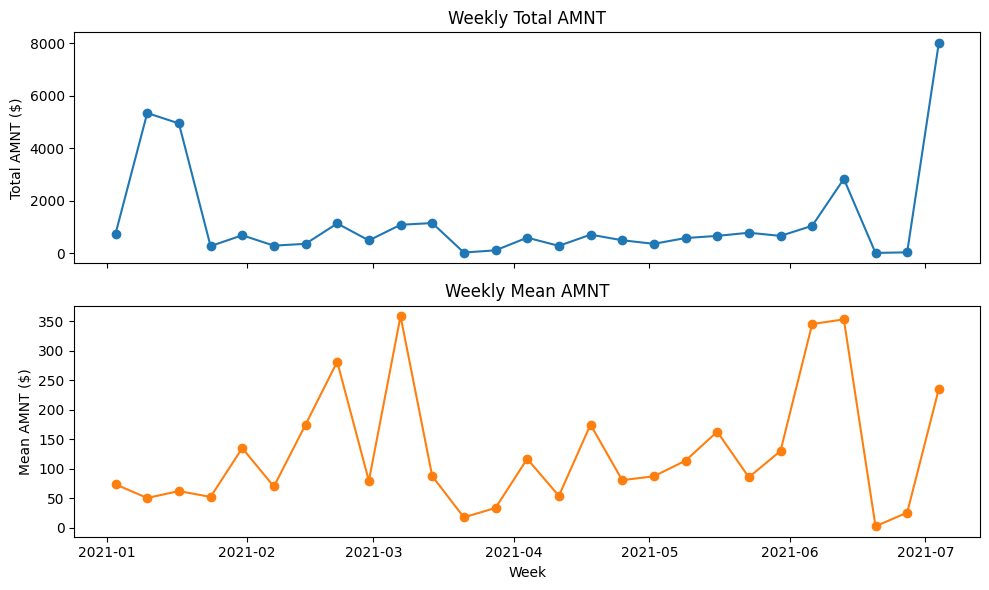

In [54]:
bc['DATE'] = pd.to_datetime(bc['DATE'])

# Optional: limit to a specific date range
start_date = '2021-1-01'
end_date = '2021-07-01'
wc_filtered = bc[(bc['DATE'] >= start_date) & (bc['DATE'] <= end_date)]

# Set DATE as index for resampling
wc_filtered.set_index('DATE', inplace=True)

# Resample by week and calculate total and mean AMNT
weekly_summary = wc_filtered['AMNT'].resample('W').agg(['sum', 'mean'])

# Plot
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Total AMNT by week
ax[0].plot(weekly_summary.index, weekly_summary['sum'], marker='o', color='tab:blue')
ax[0].set_title('Weekly Total AMNT')
ax[0].set_ylabel('Total AMNT ($)')

# Mean AMNT by week
ax[1].plot(weekly_summary.index, weekly_summary['mean'], marker='o', color='tab:orange')
ax[1].set_title('Weekly Mean AMNT')
ax[1].set_ylabel('Mean AMNT ($)')
ax[1].set_xlabel('Week')

plt.tight_layout()
plt.show()

In [59]:
we = pd.read_csv('../data/won_exp.csv')
be = pd.read_csv('../data/bagga_exp.csv')

In [61]:
we.columns

Index(['ELECTION', 'OFFICECD', 'CANDID', 'CANCLASS', 'CANDLAST', 'CANDFIRST',
       'CANDMI', 'COMMITTEE', 'FILING', 'SCHEDULE', 'PAGENO', 'SEQUENCENO',
       'REFNO', 'INV_DATE', 'DATE', 'NAME', 'C_CODE', 'ORG_IND', 'STRNO',
       'STRNAME', 'APARTMENT', 'CITY', 'STATE', 'ZIP', 'PAY_METHOD', 'AMNT',
       'PURPOSECD', 'PURPOSE', 'EXPLAIN', 'EXEMPTCD', 'RR_IND', 'SEG_IND'],
      dtype='object')

In [77]:
be.groupby('PURPOSE')['AMNT'].sum().reset_index().sort_values('AMNT',ascending=False)

PURPOSE       AMNT
8      Prof. Srvcs.  115573.40
1   Campgn Consuls.   85772.59
5  Other: explntion   11357.73
6   Petition Expns.    6043.81
9   Television Ads.    4346.00
3   Campgn Wrkrs $$    3895.00
7         Print Ads    2868.62
2       Campgn Lit.    2856.76
0  Advance Repaymnt    2023.30
4   Office Expenses     840.65

In [84]:
be[be['PURPOSE'] == 'Campgn Consuls.'][[ 'COMMITTEE','DATE', 'NAME', 'C_CODE', 'ORG_IND','PAY_METHOD', 'AMNT',
       'PURPOSECD', 'PURPOSE', 'EXPLAIN', 'EXEMPTCD', 'RR_IND', 'SEG_IND']].groupby('NAME')['AMNT'].sum().reset_index().sort_values('AMNT',ascending=False)

NAME      AMNT
0    Berkowitz, Nicholas  16242.50
7          Parson, Emily  11687.50
1     Bringuez, Brittney  11025.00
11   Underdog Strategies   8250.00
6       Nazarian, Alexia   7710.09
3         Craig, Matthew   7000.00
8        Polik, Virginia   6437.50
10        Shirkey, Jared   6325.00
2       Cantos, Aracelly   4350.00
4   Kochar McCabe, Kiran   4125.00
9          Rasik, Kowsik   2020.00
5           Leff, Philip    600.00

In [85]:
we[we['PURPOSE'] == 'Campgn Consuls.'][[ 'COMMITTEE','DATE', 'NAME', 'C_CODE', 'ORG_IND','PAY_METHOD', 'AMNT',
       'PURPOSECD', 'PURPOSE', 'EXPLAIN', 'EXEMPTCD', 'RR_IND', 'SEG_IND']].groupby('NAME')['AMNT'].sum().reset_index().sort_values('AMNT',ascending=False)

NAME      AMNT
10                 Rubin, Moses  36939.29
3                  Hom, Peter B  29250.00
7   North Shore Strategies, LLC  13775.00
1            Blasenstein, Isaac  13532.14
6              Muccioli, Thomas  10675.00
14              Tseyang, Tenzin   9425.00
12                   Soto, Eric   8225.00
5              Mohammed, Doreen   5625.00
8                  Perez, Karla   3000.00
16                 Verlute, LLC   3000.00
4                  Hong, Daniel   2700.00
17               Vosarogo, John   2250.00
15         Vera Martinez, Neily   2250.00
2                     Ho, Helen   2025.00
0                 Ahasan, Purna   1800.00
9          Red Horse Strategies   1250.00
13              Talukder, Isfir   1125.00
11               Shabana, Yarah    975.00

In [78]:
we.groupby('PURPOSE')['AMNT'].sum().reset_index().sort_values('AMNT',ascending=False)

PURPOSE       AMNT
1    Campgn Consuls.  147821.43
7   Other: explntion   67726.49
3       Campgn Mlngs   25919.19
12      Prof. Srvcs.   22899.72
2        Campgn Lit.   19053.92
11         Print Ads   14875.00
6    Office Expenses    5409.84
0   Advance Repaymnt    1723.86
4    Campgn Wrkrs $$     891.00
8    Petition Expns.     481.32
9      Polling Costs     131.37
5    Interest Expns.     121.62
10           Postage      91.20

In [ ]:
e_cats_da = ['Online Ads','Digital Ads']

In [79]:
be[be['PURPOSE'] == 'Prof. Srvcs.'].groupby('EXPLAIN')['AMNT'].sum().reset_index().sort_values('AMNT',ascending=False)

EXPLAIN      AMNT
23              mailings  55490.30
16        calling voters  10624.92
33   post election legal   6000.00
30    palm cards/posters   5747.21
10        Voter Outreach   4053.48
22   mailers and mailing   4001.16
39  senior field organiz   3500.00
34     postage 4 mailers   3262.32
9            Voter Files   3244.70
26            palm cards   2095.84
41      translation srvs   1890.00
4         Graphic Design   1800.00
31  palms/posters/hanger   1464.38
25            online ads   1436.32
3    Google Ad Placemnts   1293.70
11         Website Build   1200.00
12       Website Hosting   1000.00
38    screen printing Ts    957.01
29  palm cards (spanish)    871.00
7            Texting App    846.88
28  palm cards (eng/span    789.34
35               posters    653.25
14             bank fees    403.00
5             Online Ads    400.00
32           photo/video    360.45
2        Field Organizer    300.00
1       Donor Management    272.19
36    posters/palm cards    212.31
18          copy writing    200.00
17        campaign video    200.00
27   palm cards (arabic)    190.53
21   graphic design/logo    170.00
6          Poster Design    125.00
42     vol signup copies    109.23
24      music at kickoff    100.00
40                 signs     78.38
13        bangla RCV vid     75.00
0   1099s for contractor     48.50
8       Video subtitling     38.00
20             e-signing     32.68
19             e signing     16.34
37              research      9.99
15   business periodical      9.99

In [68]:
we.groupby('PURPOSE')['AMNT'].sum()

PURPOSE
Advance Repaymnt      1723.86
Campgn Consuls.     147821.43
Campgn Lit.          19053.92
Campgn Mlngs         25919.19
Campgn Wrkrs $$        891.00
Interest Expns.        121.62
Office Expenses       5409.84
Other: explntion     67726.49
Petition Expns.        481.32
Polling Costs          131.37
Postage                 91.20
Print Ads            14875.00
Prof. Srvcs.         22899.72
Name: AMNT, dtype: float64

In [69]:
we[we['PURPOSE'] == 'Other: explntion'][['PURPOSECD', 'PURPOSE', 'EXPLAIN','AMNT']]

PURPOSECD           PURPOSE               EXPLAIN     AMNT
3       OTHER  Other: explntion  Canvassing Refreshme    53.10
4       OTHER  Other: explntion          Banking Fees     4.00
5       OTHER  Other: explntion          Banking Fees    25.50
6       OTHER  Other: explntion          Banking Fees    20.00
7       OTHER  Other: explntion          Banking Fees    20.75
..        ...               ...                   ...      ...
330     OTHER  Other: explntion         Tranportation    14.37
331     OTHER  Other: explntion       Billed in Error     8.24
333     OTHER  Other: explntion      Video Production  3000.00
335     OTHER  Other: explntion      Video Production  3250.00
336     OTHER  Other: explntion      Video Production  3250.00

[137 rows x 4 columns]

In [73]:
we[we['PURPOSE'] == 'Other: explntion'].groupby('EXPLAIN')['AMNT'].sum().reset_index().sort_values('AMNT',ascending=False)

EXPLAIN      AMNT
12           Digital Ads  32000.00
34      Video Production   9500.00
13     Digital Truck Ads   5650.00
7   Campaign Sweatshirts   3080.00
15    Election Day Party   3010.26
30           Stripe Fees   2682.03
23   Post Election Audit   1750.00
35         Video filming   1500.00
28    Staff Appreciation   1332.83
5       Campaign Beanies   1020.15
21           Masks,Totes    582.38
20                 Masks    567.82
3           Banking Fees    530.14
36  Volunteer Appreciati    486.79
18  Gala Awards Ceremony    400.00
9   Canvassing Refreshme    386.62
1         Audio services    370.18
37      Volunteer Dinner    351.24
10       Community Event    329.91
32        Text Messaging    299.82
11     Community contact    276.80
25     Rally Speaker/Mic    251.90
39  Volunteer management    163.31
33         Tranportation    153.12
27          Space Rental    150.00
38        Volunteer Meal    139.03
29          Staff Dinner    126.96
22  Ponchos for Canvasse     88.89
26  Social Media Platfor     81.66
16  Food for E-day staff     63.31
8       Candelight Vigil     58.76
31       Table for E Day     50.06
19     Laptop Stand GOTV     50.03
14          District Map     48.62
0     1099-NEC Tax Forms     46.81
17     GOTV Rally permit     45.00
41       poster supplies     32.09
24         Poster design     25.00
2   Ballot Canvass Forms     17.64
6         Campaign Lunch     14.09
4        Billed in Error      8.24
40          banking fees      5.00

In [63]:
we[[ 'COMMITTEE','DATE', 'NAME', 'C_CODE', 'ORG_IND','PAY_METHOD', 'AMNT',
       'PURPOSECD', 'PURPOSE', 'EXPLAIN', 'EXEMPTCD', 'RR_IND', 'SEG_IND']].sample(10)

COMMITTEE        DATE                            NAME C_CODE ORG_IND  \
46          H  11/27/2020                Amalgamated Bank   CORP       Y   
56          H   4/19/2021                        Bee Cafe    LLC       Y   
206         H    6/6/2021                     Pizza Boy 2    LLC       Y   
167         H  12/28/2020  New York State Democratic Comm  PCOMZ       Y   
122         H  11/16/2022                    Hom, Peter B    IND       N   
241         H  10/26/2021  Scheck Outdoor Advertising LLC    LLC       Y   
326         H  10/22/2021                      Won, Julie    IND       N   
2           H  10/20/2021                   Ahasan, Purna    IND       N   
279         H   3/31/2021   Stripe - NYC Votes Contribute   CORP       Y   
144         H   5/17/2021   Lamar Advertising of New York   CORP       Y   

    PAY_METHOD     AMNT PURPOSECD           PURPOSE               EXPLAIN  \
46     Unknown     6.47     OTHER  Other: explntion          Banking Fees   
56     Unknown     6.17     OTHER  Other: explntion  Canvassing Refreshme   
206    Unknown    10.00     OTHER  Other: explntion  Canvassing Refreshme   
167    Unknown  3500.00     OFFCE   Office Expenses     Voter file access   
122    Unknown  1750.00     OTHER  Other: explntion   Post Election Audit   
241    Unknown  1050.00     OTHER  Other: explntion     Digital Truck Ads   
326    Advance    10.92     ADVAN  Advance Repaymnt     Advance Repayment   
2      Unknown   900.00     CONSL   Campgn Consuls.      Field Organizing   
279    Unknown    15.49     OTHER  Other: explntion           Stripe Fees   
144    Unknown  3725.00     PRINT         Print Ads                Poster   

    EXEMPTCD RR_IND SEG_IND  
46       NaN      N       N  
56       NaN      N       N  
206      NaN      N       N  
167      NaN      N       N  
122      NaN      N       N  
241      NaN      N       N  
326      NaN      N       N  
2        NaN      N       N  
279      NaN      N       N  
144      NaN      N       N

C:\Users\samtg\AppData\Local\Temp\ipykernel_12324\661500944.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  wc_filtered = we[(bc['DATE'] >= start_date) & (we['DATE'] <= end_date)]


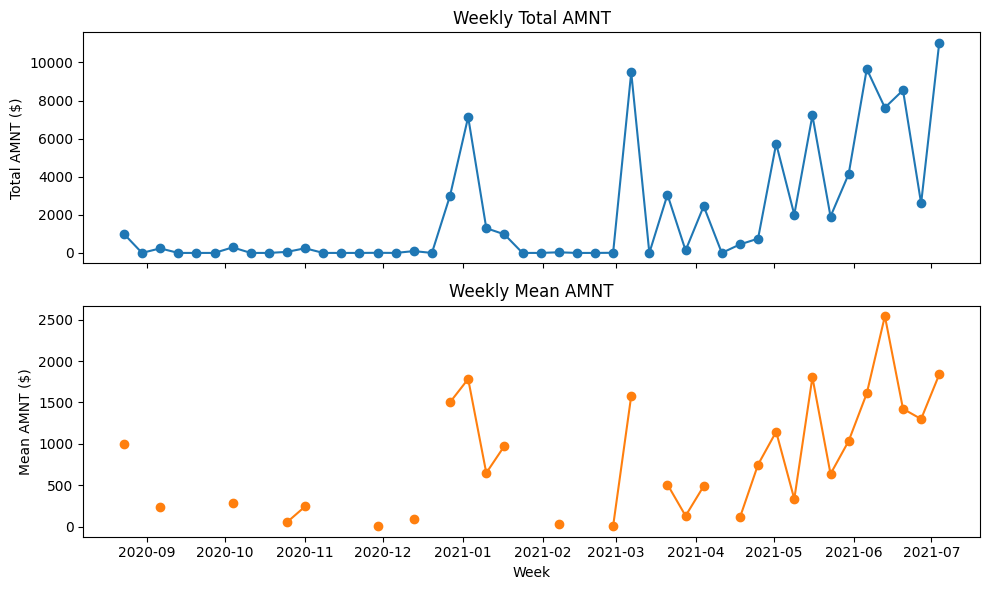

In [86]:
we['DATE'] = pd.to_datetime(we['DATE'])

# Optional: limit to a specific date range
start_date = '2021-1-01'
end_date = '2021-07-01'
wc_filtered = we[(bc['DATE'] >= start_date) & (we['DATE'] <= end_date)]

# Set DATE as index for resampling
wc_filtered.set_index('DATE', inplace=True)

# Resample by week and calculate total and mean AMNT
weekly_summary = wc_filtered['AMNT'].resample('W').agg(['sum', 'mean'])

# Plot
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Total AMNT by week
ax[0].plot(weekly_summary.index, weekly_summary['sum'], marker='o', color='tab:blue')
ax[0].set_title('Weekly Total AMNT')
ax[0].set_ylabel('Total AMNT ($)')

# Mean AMNT by week
ax[1].plot(weekly_summary.index, weekly_summary['mean'], marker='o', color='tab:orange')
ax[1].set_title('Weekly Mean AMNT')
ax[1].set_ylabel('Mean AMNT ($)')
ax[1].set_xlabel('Week')

plt.tight_layout()
plt.show()

In [106]:
m_e = ['mailings','calling voters','palm cards','Voter Outreach','Online Ads','online ads','GOTV Mailer',
'Palm Cards','Digital Truck Ads','Social Media','Digital Ads','Direct Mail','Poster','Ads','mailings','palm cards/posters','calling voters','Online Campaign Ad',
 'mailers and mailing']

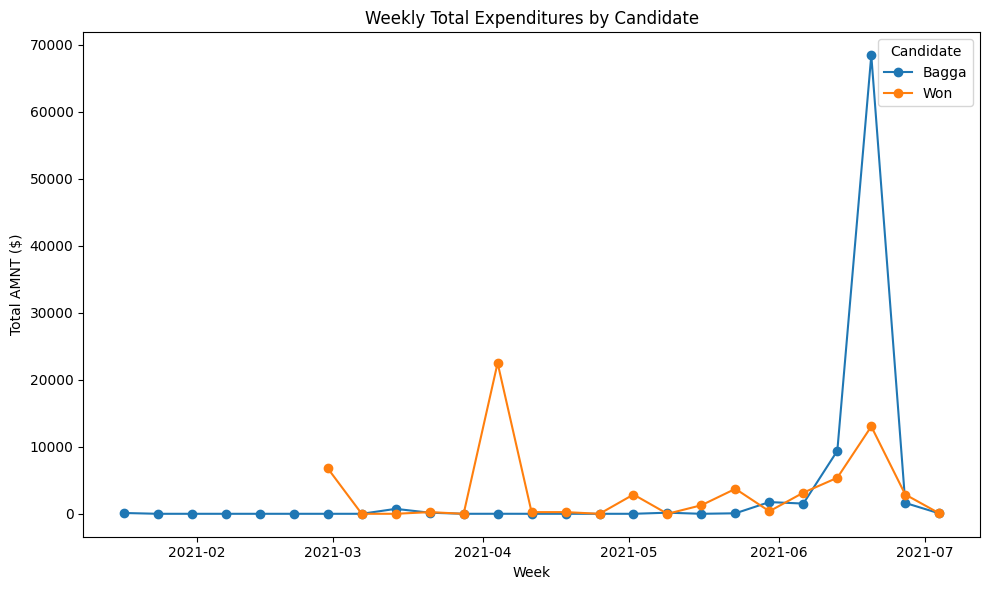

In [107]:
we['DATE'] = pd.to_datetime(we['DATE'])
be['DATE'] = pd.to_datetime(be['DATE'])

we['Candidate'] = 'Won'
be['Candidate'] = 'Bagga'

df = pd.concat([we, be], ignore_index=True)

start_date = '2021-01-01'
end_date = '2021-07-01'
df = df[(df['DATE'] >= start_date) & (df['DATE'] <= end_date)]
df = df[df['EXPLAIN'].isin(m_e)]

weekly_summary = (
    df.set_index('DATE')
      .groupby('Candidate')['AMNT']
      .resample('W')
      .sum()
      .reset_index()
)


plt.figure(figsize=(10, 6))
for name, group in weekly_summary.groupby('Candidate'):
    plt.plot(group['DATE'], group['AMNT'], marker='o', label=name)

plt.title('Weekly Total Expenditures by Candidate')
plt.ylabel('Total AMNT ($)')
plt.xlabel('Week')
plt.legend(title='Candidate')
plt.tight_layout()
plt.show()

Donor Data 

In [1]:
from ethnicolr import pred_census_ln, pred_wiki_name

c:\Users\samtg\github\member_chapters\venv\Lib\site-packages\ethnicolr\pred_census_ln.py:14: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


In [4]:
won_don = pd.read_csv('../data/won_donations.csv')
bagga_don = pd.read_csv('../data/bagga_donations.csv')

In [6]:
won_don[['NAME', 'C_CODE', 'NAME','AMNT']]

NAME C_CODE                            NAME  \
0    1199 SEIU - NYS Political Acti  PCOMP  1199 SEIU - NYS Political Acti   
1                        Abdo, Omar    IND                      Abdo, Omar   
2                      Abowd, Naina    IND                    Abowd, Naina   
3                     Ahern, Emilie    IND                   Ahern, Emilie   
4                         Ahn, John    IND                       Ahn, John   
..                              ...    ...                             ...   
781                   Zee, Anabelle    IND                   Zee, Anabelle   
782                      Zhang, Wei    IND                      Zhang, Wei   
783                   Zhou, William    IND                   Zhou, William   
784                    Zhuo, George    IND                    Zhuo, George   
785                  Zlotnik, Asher    IND                  Zlotnik, Asher   

       AMNT  
0    1000.0  
1      25.0  
2      25.0  
3      10.0  
4      50.0  
..      ...  
781   100.0  
782    25.0  
783    25.0  
784   175.0  
785   100.0  

[786 rows x 4 columns]

In [23]:
won_ind = won_don[won_don['C_CODE'] == 'IND']
bagga_ind = bagga_don[bagga_don['C_CODE'] == 'IND']

In [10]:
won_ind[['NAME','ZIP','AMNT']].head(5).to_clipboard()

In [ ]:
def split_name(name):
    if pd.isna(name):
        return pd.Series({"last":"", "first":""})
    name = str(name).strip()
    if ',' in name:
        last, first = name.split(',', 1)
        return pd.Series({"last": last.strip(), "first": first.strip()})
    parts = name.split()
    if len(parts) == 0:
        return pd.Series({"last":"", "first":""})
    if len(parts) == 1:
        return pd.Series({"last": parts[0], "first": ""})
    return pd.Series({"last": parts[-1], "first": " ".join(parts[:-1])})

name_parts = won_ind['NAME'].apply(split_name)
won_ind = pd.concat([won_ind, name_parts], axis=1)
won_ind['first'] = won_ind['first'].astype(str)
won_ind['last'] = won_ind['last'].astype(str)

In [ ]:
df = won_ind[['first','last','NAME','ZIP','AMNT']]
orig_cols = set(df.columns)
df_out = pred_wiki_name(df.copy(), 'last', 'first')

In [14]:
df_out = pred_wiki_name(df.copy(), 'last', 'first')

2025-10-26 16:15:10,191 - INFO - Processing 781 names
2025-10-26 16:15:10,523 - INFO - Applying Wikipedia name model to 781 processable names (confidence interval: 1.0)
2025-10-26 16:15:10,751 - INFO - Preserving 77 duplicate rows based on column '__ethnicolr_temp_name'
2025-10-26 16:15:10,761 - INFO - Data filtering summary: 781 → 781 rows (kept 100.0%)
2025-10-26 16:15:15,357 - INFO - Successfully predicted 781 of 781 names (100.0%)
2025-10-26 16:15:15,360 - INFO - Added columns: __name, Asian,GreaterEastAsian,Japanese, GreaterEuropean,WestEuropean,French, GreaterEuropean,British, Asian,IndianSubContinent, GreaterEuropean,WestEuropean,Hispanic, GreaterEuropean,WestEuropean,Germanic, race, GreaterAfrican,Muslim, GreaterEuropean,EastEuropean, processing_status, name_normalized_clean, GreaterAfrican,Africans, name_normalized, GreaterEuropean,WestEuropean,Nordic, GreaterEuropean,Jewish, Asian,GreaterEastAsian,EastAsian, GreaterEuropean,WestEuropean,Italian


In [22]:
won_with_eth = df_out.copy()

In [24]:
name_parts = bagga_ind['NAME'].apply(split_name)
bagga_ind = pd.concat([bagga_ind, name_parts], axis=1)

# ensure strings
bagga_ind['first'] = bagga_ind['first'].astype(str)
bagga_ind['last'] = bagga_ind['last'].astype(str)

In [ ]:
df = bagga_ind[['first','last','NAME','ZIP','AMNT']]
orig_cols = set(df.columns)
bagga_with_eth = pred_wiki_name(df.copy(), 'last', 'first')

In [26]:
bagga_with_eth = pred_wiki_name(df.copy(), 'last', 'first')

2025-10-26 16:22:51,769 - INFO - Processing 656 names
2025-10-26 16:22:51,848 - INFO - Applying Wikipedia name model to 656 processable names (confidence interval: 1.0)
2025-10-26 16:22:51,878 - INFO - Preserving 73 duplicate rows based on column '__ethnicolr_temp_name'
2025-10-26 16:22:51,881 - INFO - Data filtering summary: 656 → 656 rows (kept 100.0%)
2025-10-26 16:22:53,185 - INFO - Successfully predicted 656 of 656 names (100.0%)
2025-10-26 16:22:53,188 - INFO - Added columns: __name, Asian,GreaterEastAsian,Japanese, GreaterEuropean,WestEuropean,French, GreaterEuropean,British, Asian,IndianSubContinent, GreaterEuropean,WestEuropean,Hispanic, GreaterEuropean,WestEuropean,Germanic, race, GreaterAfrican,Muslim, GreaterEuropean,EastEuropean, processing_status, name_normalized_clean, GreaterAfrican,Africans, name_normalized, GreaterEuropean,WestEuropean,Nordic, GreaterEuropean,Jewish, Asian,GreaterEastAsian,EastAsian, GreaterEuropean,WestEuropean,Italian


In [27]:
bagga_with_eth['race'].value_counts()

race
GreaterEuropean,British                  262
GreaterEuropean,Jewish                   110
Asian,IndianSubContinent                  74
GreaterEuropean,WestEuropean,Italian      47
GreaterEuropean,WestEuropean,Hispanic     38
Asian,GreaterEastAsian,EastAsian          31
GreaterEuropean,WestEuropean,French       29
GreaterAfrican,Muslim                     23
GreaterAfrican,Africans                   13
GreaterEuropean,EastEuropean              13
GreaterEuropean,WestEuropean,Germanic      8
GreaterEuropean,WestEuropean,Nordic        7
Asian,GreaterEastAsian,Japanese            1
Name: count, dtype: int64

In [31]:
bagga_with_eth.groupby('race')['AMNT'].agg(['mean','sum','count']).round(3).reset_index().sort_values('count',ascending=False)

race     mean       sum  count
5                 GreaterEuropean,British  101.018  26466.75    262
7                  GreaterEuropean,Jewish  102.891  11318.00    110
2                Asian,IndianSubContinent  159.095  11773.00     74
11   GreaterEuropean,WestEuropean,Italian  119.809   5631.00     47
10  GreaterEuropean,WestEuropean,Hispanic   65.816   2501.00     38
0        Asian,GreaterEastAsian,EastAsian   52.452   1626.00     31
8     GreaterEuropean,WestEuropean,French   96.517   2799.00     29
4                   GreaterAfrican,Muslim  124.261   2858.00     23
3                 GreaterAfrican,Africans   84.069   1092.90     13
6            GreaterEuropean,EastEuropean   61.769    803.00     13
9   GreaterEuropean,WestEuropean,Germanic  247.000   1976.00      8
12    GreaterEuropean,WestEuropean,Nordic   58.714    411.00      7
1         Asian,GreaterEastAsian,Japanese   50.000     50.00      1

In [32]:
won_with_eth.groupby('race')['AMNT'].agg(['mean','sum','count']).round(3).reset_index().sort_values('count',ascending=False)

race     mean       sum  count
0        Asian,GreaterEastAsian,EastAsian  145.005  55972.00    386
5                 GreaterEuropean,British   89.817  19580.21    218
7                  GreaterEuropean,Jewish   76.533   3444.00     45
11   GreaterEuropean,WestEuropean,Italian  111.000   3996.00     36
10  GreaterEuropean,WestEuropean,Hispanic   55.431   1385.78     25
2                Asian,IndianSubContinent   76.333   1374.00     18
3                 GreaterAfrican,Africans  106.000   1060.00     10
4                   GreaterAfrican,Muslim   36.667    330.00      9
8     GreaterEuropean,WestEuropean,French  156.667   1410.00      9
12    GreaterEuropean,WestEuropean,Nordic   68.333    615.00      9
1         Asian,GreaterEastAsian,Japanese  191.667   1150.00      6
6            GreaterEuropean,EastEuropean   79.000    395.00      5
9   GreaterEuropean,WestEuropean,Germanic   57.000    285.00      5